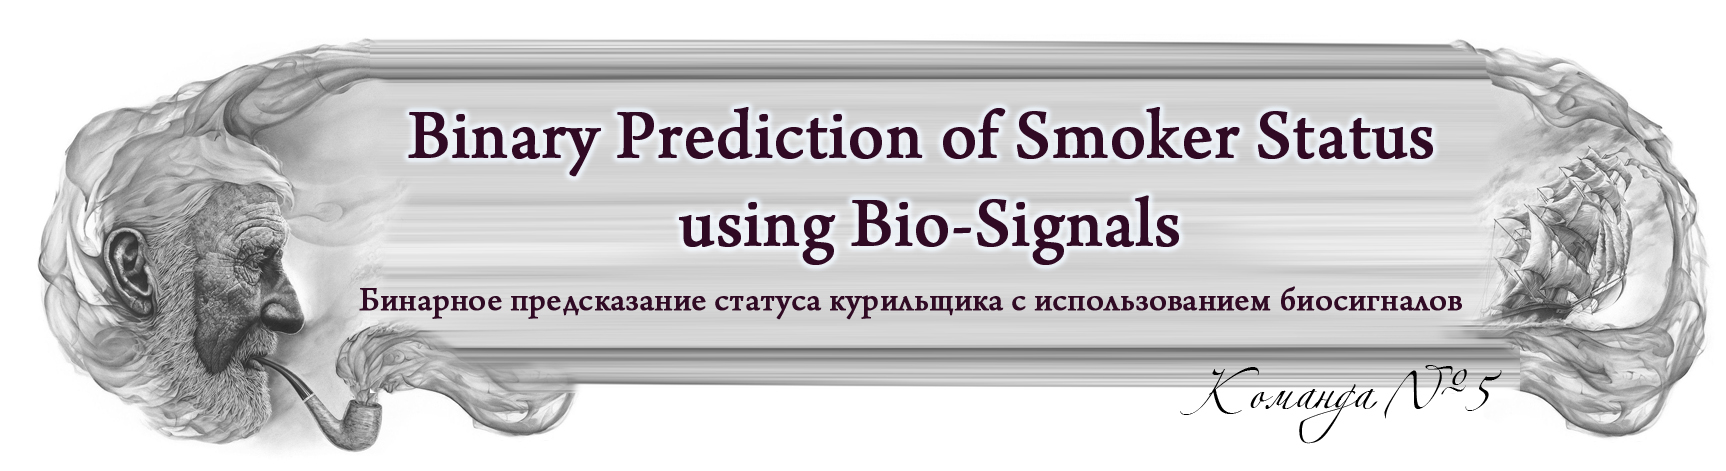

In [1]:
from IPython.display import Image
Image('binary_smoker.jpg')


**Это датасет по классификации пациентов на основе различных измерений (био-сигналов). Датасет размещен по ссылке:
https://www.kaggle.com/competitions/playground-series-s3e24/data**

С целями разработки проекта можно ознакомиться здесь (https://www.kaggle.com/datasets/gauravduttakiit/smoker-status-prediction-using-biosignals), поскольку наш датасет был сформирован на основании вышеуказанного.

Так, составители датасета указали, что многие врачи прекратили консультирование пациентов по вопросу отказа от курения ввиду неэффективности. В частности, многие пациенты возвращались к вредной привычке, несмотря на врачебные предписания. Чтобы преодолеть эту проблему, было предложено обучить модель выявлять признаки, которые отличали бы курящих людей от некурящих, чтобы на основании этих признаков врачи имели возможность выявлять пациентов, которые имеют больше шансов бросить курить.

В датасете используются следующие признаки признаки: возраст, рост(см), вес(кг), талия(см), зрение(левый глаз и правый), слух (левое и право ухо), артериальное давление (верхнее систолическое и нижнее дистолическое), уровень сахара в крови натощак, холестерин (общий, а также LDL и HDL), триглицериды, гемоглобин, белок мочи, сывороточный креатинин, АСТ, АЛТ, ГТП(гамма-глутамилтранспептидаза), кариес зубов.

Целевой переменной является статус курения (0 - не курит, 1 - курит).


**В первую очередь обзорно исследуем датасет**

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import GridSearchCV


In [5]:
df = pd.read_csv("train.csv", index_col='id') # Импорт датасета для обучения, столбец 'id' взят как индекс строк

In [8]:
raw_df = df.copy() # создание копии "сырого" датафрейма

In [10]:
raw_X_train = raw_df.drop(columns = ['smoking']) # разделение "сырого" датафрейма на признаки и таргетную переменную
raw_y_train = raw_df['smoking']

In [12]:
df_test = pd.read_csv("test.csv", index_col='id')
raw_df_test = df_test.copy() # создание копии "сырой" тестовой выборки

In [14]:
raw_model = LogisticRegression(solver='liblinear', random_state=42) # единые параметры для "сырых" и предобработанных данных 
                                                                    # для воспроизводимости результатов

In [16]:
raw_model.fit(raw_X_train, raw_y_train) # обучение модели
raw_y_train_pred = raw_model.predict(raw_X_train) # предсказание целевой переменной

In [17]:
raw_accuracy = accuracy_score(raw_y_train, raw_y_train_pred)
raw_precision = precision_score(raw_y_train, raw_y_train_pred)
raw_recall = recall_score(raw_y_train, raw_y_train_pred)
raw_f1 = f1_score(raw_y_train, raw_y_train_pred)
raw_roc_auc = roc_auc_score(raw_y_train, raw_model.predict_proba(raw_X_train)[:, 1])

print(f'Accuracy for raw DataFrame: {raw_accuracy}')
print(f'Precision for raw DataFrame: {raw_precision}')
print(f'Recall for raw DataFrame: {raw_recall}')
print(f'F1 Score for raw DataFrame: {raw_f1}')
print(f'ROC AUC for raw DataFrame: {raw_roc_auc}')

Accuracy for raw DataFrame: 0.7488823027075903
Precision for raw DataFrame: 0.7042627918187453
Recall for raw DataFrame: 0.7341105192884728
F1 Score for raw DataFrame: 0.7188769700122313
ROC AUC for raw DataFrame: 0.8346544260422117


In [20]:
print(df.info()) # В датасете 23 признака и таргетная переменна smoking

<class 'pandas.core.frame.DataFrame'>
Index: 159256 entries, 0 to 159255
Data columns (total 23 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   age                  159256 non-null  int64  
 1   height(cm)           159256 non-null  int64  
 2   weight(kg)           159256 non-null  int64  
 3   waist(cm)            159256 non-null  float64
 4   eyesight(left)       159256 non-null  float64
 5   eyesight(right)      159256 non-null  float64
 6   hearing(left)        159256 non-null  int64  
 7   hearing(right)       159256 non-null  int64  
 8   systolic             159256 non-null  int64  
 9   relaxation           159256 non-null  int64  
 10  fasting blood sugar  159256 non-null  int64  
 11  Cholesterol          159256 non-null  int64  
 12  triglyceride         159256 non-null  int64  
 13  HDL                  159256 non-null  int64  
 14  LDL                  159256 non-null  int64  
 15  hemoglobin           1

In [22]:
print(df.describe()) 

                 age     height(cm)     weight(kg)      waist(cm)  \
count  159256.000000  159256.000000  159256.000000  159256.000000   
mean       44.306626     165.266929      67.143662      83.001990   
std        11.842286       8.818970      12.586198       8.957937   
min        20.000000     135.000000      30.000000      51.000000   
25%        40.000000     160.000000      60.000000      77.000000   
50%        40.000000     165.000000      65.000000      83.000000   
75%        55.000000     170.000000      75.000000      89.000000   
max        85.000000     190.000000     130.000000     127.000000   

       eyesight(left)  eyesight(right)  hearing(left)  hearing(right)  \
count   159256.000000    159256.000000  159256.000000   159256.000000   
mean         1.005798         1.000989       1.023974        1.023421   
std          0.402113         0.392299       0.152969        0.151238   
min          0.100000         0.100000       1.000000        1.000000   
25%          

In [24]:
print(df.columns) 

Index(['age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)',
       'eyesight(right)', 'hearing(left)', 'hearing(right)', 'systolic',
       'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride',
       'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum creatinine', 'AST',
       'ALT', 'Gtp', 'dental caries', 'smoking'],
      dtype='object')


**Рассмотрим датафрейм на наличие нулевых значений и дубликатов**

In [27]:
def duplicates_nan(df, is_train=True):
    print(f'Количество признаков, содержащих пропущенные значения: {df.isnull().any().sum()}')
    print(f'Количество пропущенных значений: {df.isnull().values.sum()}')
    
    zero_rows = df[(df == 0).all(axis=1)]
    print(f'Количество нулевых строк: {zero_rows.shape[0]}')
    
    duplicates = df[df.duplicated()]
    print(f'Дубликаты: {duplicates}')
    
    df = df[~(df == 0).all(axis=1)]
    
    if df.isnull().values.sum() > 0: # если количество пропущенных значений больше 0
        df = df.dropna(how='any') # запускаем очистку пропущенных, возвращаем измененный датасет без пропусков.
    
    if df.duplicated().sum() > 0: # если количество дубликатов больше 0
        df = df.drop_duplicates(keep='first') # запускаем очистку дубликатов, оставляем первую строку в серии дубликатов (keep='first'), возвращаем измененный датасет без дубликатов (inplace=True).
    
    return df
df = duplicates_nan(df)

Количество признаков, содержащих пропущенные значения: 0
Количество пропущенных значений: 0
Количество нулевых строк: 0
Дубликаты: Empty DataFrame
Columns: [age, height(cm), weight(kg), waist(cm), eyesight(left), eyesight(right), hearing(left), hearing(right), systolic, relaxation, fasting blood sugar, Cholesterol, triglyceride, HDL, LDL, hemoglobin, Urine protein, serum creatinine, AST, ALT, Gtp, dental caries, smoking]
Index: []

[0 rows x 23 columns]


In [29]:
print(df.shape)

(159256, 23)


**Дубликаты и нулевые значения отсутствуют**

Создадим копию датафрейма для сравнения метрик модели, обученной на данных, очищенных от выбросов

In [33]:
df_cleaned_from_outliers = df.copy()

**Разделим тренировочную выборку на признаки и целевую переменную**

In [36]:
X_train =df.drop(columns = ['smoking'])
y_train = df['smoking']

**Полагаем целесообразным произвести инжиниринг признаков для возможного улучшения качества модели. Попробуем выявить переменные, наиболее связанные с таргетной переменной**

In [39]:
#import pandas as pd
#from scipy.stats import ttest_ind
#
#num_columns = ['age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)',
#       'eyesight(right)', 'systolic',
#       'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride',
#       'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum creatinine', 'AST',
#       'ALT', 'Gtp']
#
#alpha = 0.01  # Уровень значимости
#
df_united_test = X_train.copy()
df_united_test['smoking'] = y_train.reset_index(drop=True)
print(df_united_test['smoking'].head())
#
#
#relevant_features = []
#non_relevant_features = []
#
## Перебираем все числовые признаки в датасете (кроме целевой переменной)
#for column in num_columns:
#    if column != 'smoking':  # Целевая переменная
#        # Разделяем данные на две группы по значению целевой переменной
#        group1 = df_united_test[df_united_test['smoking'] == 0][column]  # Не курит
#        group2 = df_united_test[df_united_test['smoking'] == 1][column]  # Курит
#        print(len(group1), len(group2))
#
#        # Выполняем t-тест
#        t_stat, p_value = ttest_ind(group1, group2, nan_policy='omit')
#
#        # Проверяем p-значение для отбора признаков
#        if p_value < alpha:
#            relevant_features.append(column)
#        else:
#            non_relevant_features.append(column)
#
## Вывод результатов
#print("Релевантные признаки:", relevant_features)
#print("Нерелевантные признаки:", non_relevant_features)

id
0    1
1    0
2    1
3    0
4    1
Name: smoking, dtype: int64


**Выведем тепловую карту корреляций чтобы проверить, какие признаки имеют высокую степень корреляции:**

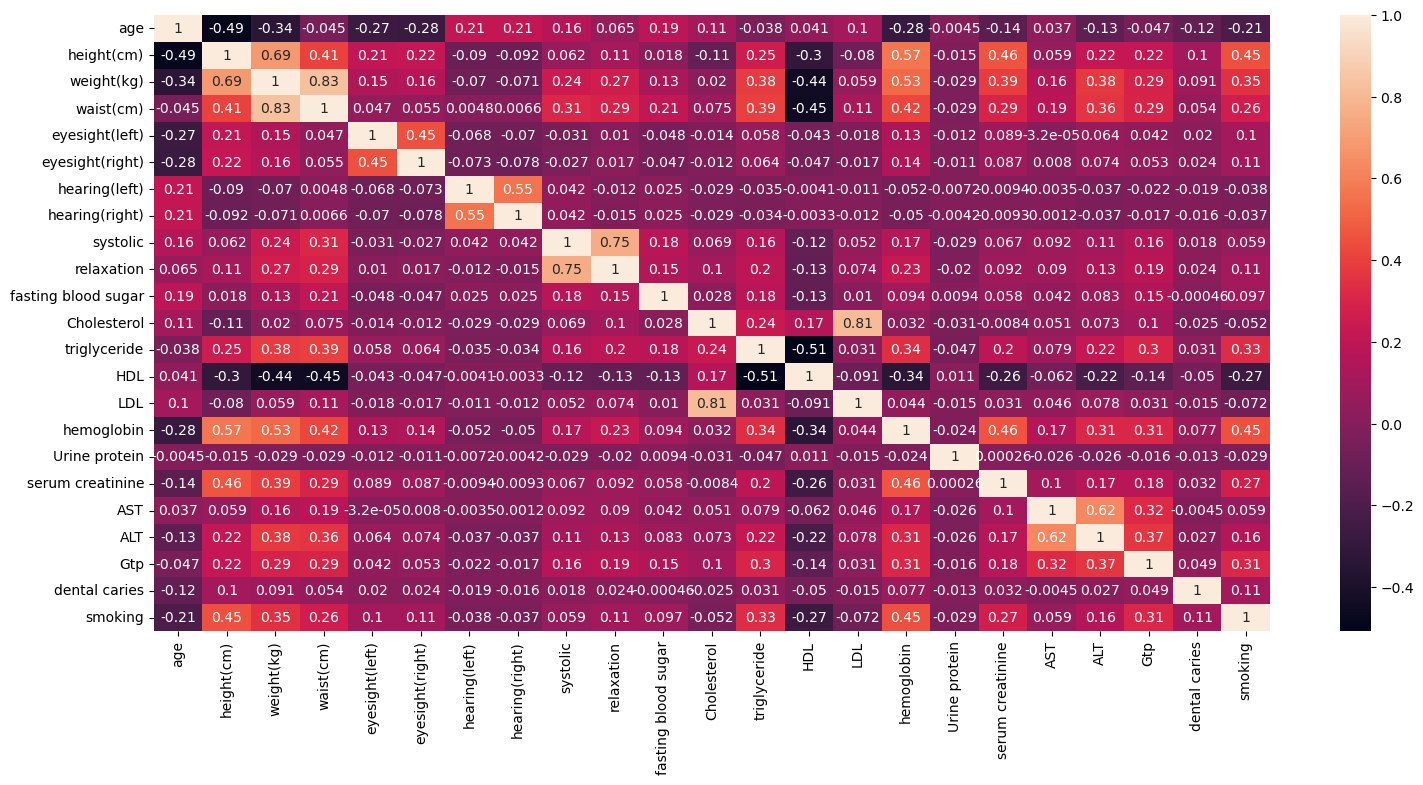

In [42]:
plt.figure(figsize=(18,8))
sns.heatmap(df_united_test.corr(), annot=True)
None

**Тест взаимной информации**

**Здесь выберем параметр score_func=mutual_info_classif, который учитывает также сложные нелинейные связи.**

In [46]:
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

bestfeature = SelectKBest(score_func=mutual_info_classif)
bestfeature.fit(X_train, y_train)
sc = bestfeature.scores_
impt_feature = pd.DataFrame({"Feature":X_train.columns,"Score":sc})
impt_feature = impt_feature.sort_values(by="Score",ascending=False)
print(impt_feature)

                Feature     Score
1            height(cm)  0.138976
15           hemoglobin  0.133564
20                  Gtp  0.099315
2            weight(kg)  0.080127
12         triglyceride  0.075157
17     serum creatinine  0.064895
3             waist(cm)  0.044972
13                  HDL  0.041748
19                  ALT  0.028775
0                   age  0.026675
16        Urine protein  0.017161
7        hearing(right)  0.016351
6         hearing(left)  0.015469
5       eyesight(right)  0.013374
8              systolic  0.012167
4        eyesight(left)  0.011997
9            relaxation  0.011683
10  fasting blood sugar  0.008760
14                  LDL  0.008566
21        dental caries  0.008414
18                  AST  0.006332
11          Cholesterol  0.005814


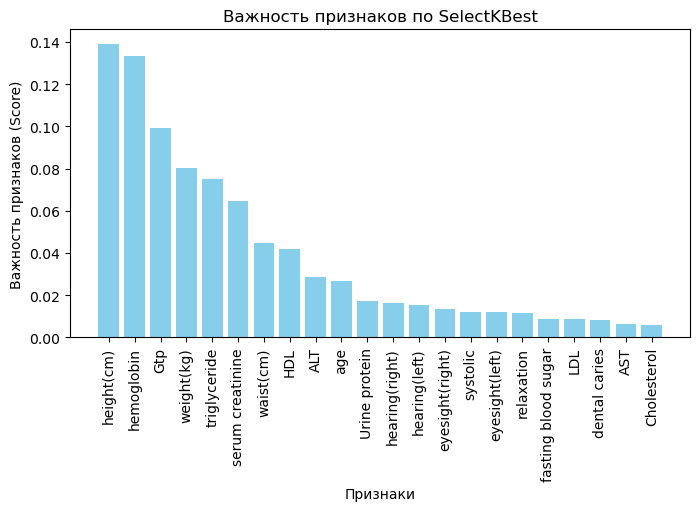

In [47]:
plt.figure(figsize=(8, 4))
plt.bar(impt_feature["Feature"], impt_feature["Score"], color="skyblue")

plt.xticks(rotation=90)
plt.xlabel("Признаки")
plt.ylabel("Важность признаков (Score)")
plt.title("Важность признаков по SelectKBest")

# Отображаем диаграмму
plt.show()

**Наиболее коррелирующими с таргетной переменной являются следующие переменные: рост, вес, объем талии, триглицириды, гемоглобин, креатинин, gtp**

**Для части признаков создадим полиномиальные признаки, чтобы в последующем протестировать, улучшают ли они метрики. Забегая вперед, заметим, что метрики классической логистической регрессионной модели без приведенных признаков следующие.**

Accuracy: 0.7584580800723364

Precision: 0.7112643615868198

Recall: 0.7536933082566436

F1 Score: 0.7318644091425545

ROC AUC: 0.8419585393052988


**В дальнейшем мы продемонстрируем метрики моделей, обученных на датасете с включенными признаками, приведенными ниже**

Добавим полиномиальные признаки на основе исходных данных:
- индекс массы тела;
- соотношение обхвата талии к росту;
- сооотношение уровня холестерина (холестерин ЛПВП к холестерину ЛПНП).

In [52]:
X_train['BMI'] = X_train['weight(kg)'] / ((X_train['height(cm)'] / 100) **2)
X_train['waist_height_ratio'] = X_train['waist(cm)'] / X_train['height(cm)']
X_train['chol_ratio'] = X_train['LDL'] / X_train['HDL']

Также добавим данные признаки в датафрейм, который впоследствии будет очищен от выбросов

In [55]:
df_cleaned_from_outliers['BMI'] = df_cleaned_from_outliers['weight(kg)'] / ((df_cleaned_from_outliers['height(cm)'] / 100) **2)
df_cleaned_from_outliers['waist_height_ratio'] = df_cleaned_from_outliers['waist(cm)'] / df_cleaned_from_outliers['height(cm)']
df_cleaned_from_outliers['chol_ratio'] = df_cleaned_from_outliers['LDL'] / df_cleaned_from_outliers['HDL']

Проверим полученные значения:

In [58]:
print(X_train[['BMI', 'waist_height_ratio', 'chol_ratio']].describe()) #проверим полученные значения

                 BMI  waist_height_ratio     chol_ratio
count  159256.000000       159256.000000  159256.000000
mean       24.452825            0.502491       2.183459
std         3.368651            0.050137       0.750977
min        11.718750            0.300000       0.021739
25%        22.222222            0.468571       1.653061
50%        24.221453            0.500000       2.142857
75%        26.159334            0.535172       2.660714
max        45.785640            0.793750      39.574468


**Посмотрим, какие значения наблюдаются в признаках**

In [61]:
X_train.head() # [159256 строк x 26 столбца]


,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,BMI,waist_height_ratio,chol_ratio
id,,,,,,,,,,,,,,,,,,,,,
0,55,165,60,81.0,0.5,0.6,1,1,135,87,...,16.5,1,1.0,22,25,27,0,22.038567,0.490909,1.875000
1,70,165,65,89.0,0.6,0.7,2,2,146,83,...,16.2,1,1.1,27,23,37,1,23.875115,0.539394,2.210526
2,20,170,75,81.0,0.4,0.5,1,1,118,75,...,17.4,1,0.8,27,31,53,0,25.951557,0.476471,2.066667
3,35,180,95,105.0,1.5,1.2,1,1,131,88,...,15.9,1,1.0,20,27,30,1,29.320988,0.583333,2.684211
4,30,165,60,80.5,1.5,1.0,1,1,121,76,...,15.4,1,0.8,19,13,17,0,22.038567,0.487879,2.113636


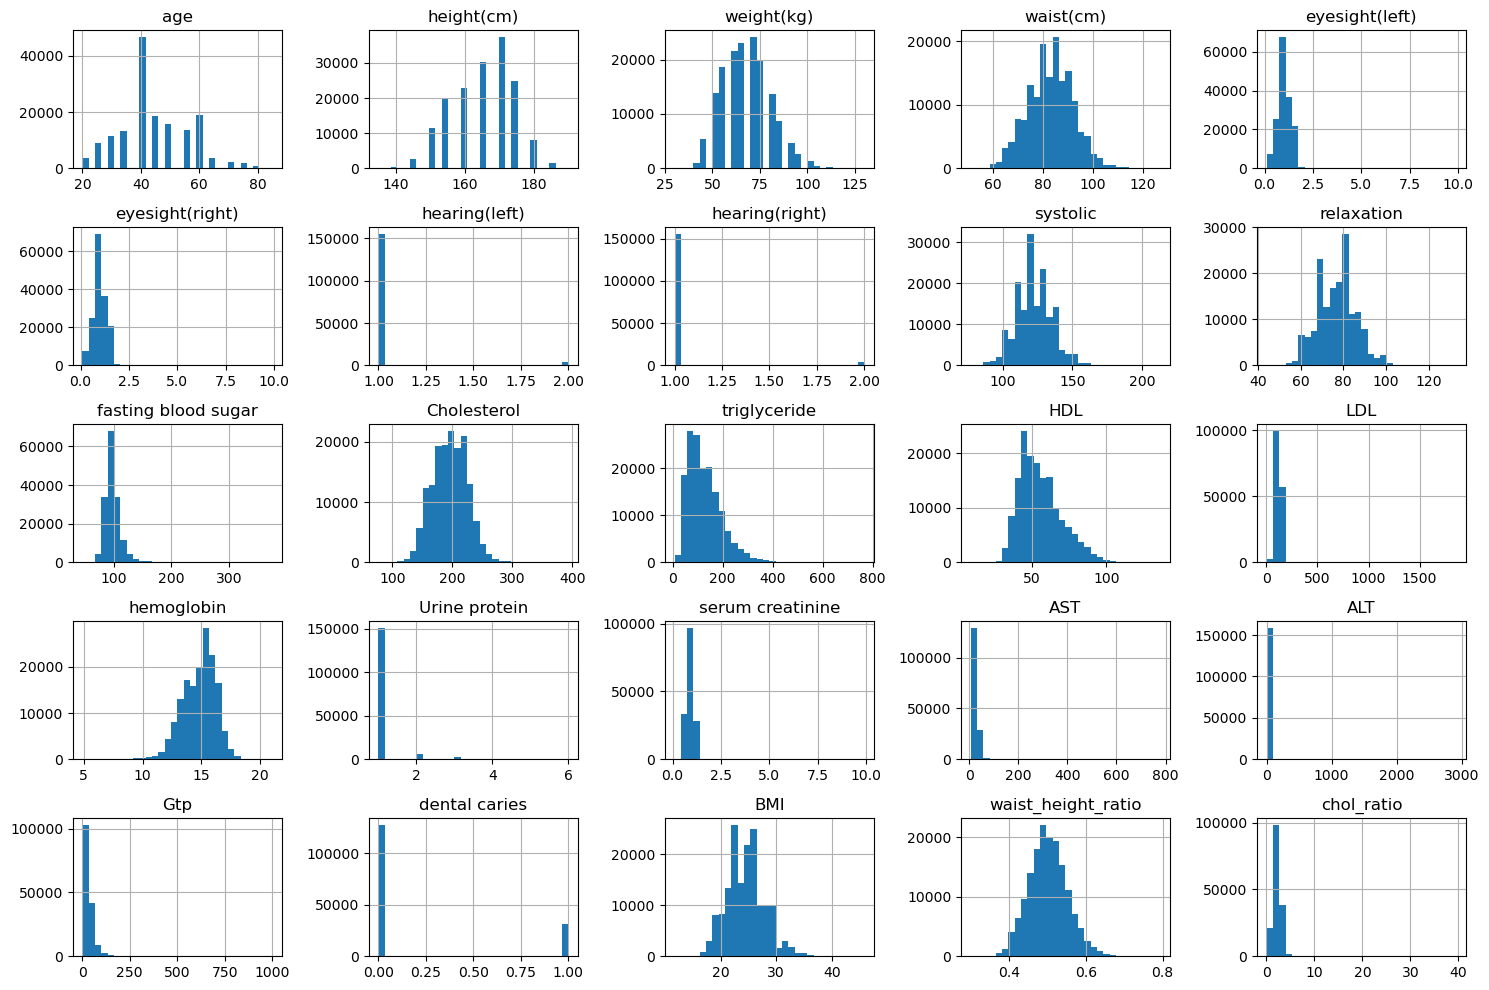

In [63]:
X_train.hist(bins=30, figsize=(15, 10))
plt.tight_layout() # подбирает оптимальное расположение подграфиков для достижения наиболее аккуратного отображения
None

**Мы обнаружили, что некоторые признаки имеют значения небольших натуральных чисел. Рассмотрим, какие значения встречаются по этим признакам, чтобы определить, имеют ли они бинарную структуру**

In [66]:
columns_un_values = ['hearing(left)', 'hearing(right)', 'Urine protein', 'dental caries']
def check_unique(dataframe):
    for column in columns_un_values:
        print(dataframe[column].value_counts())
     
print(check_unique(X_train))
X_train

hearing(left)
1    155438
2      3818
Name: count, dtype: int64
hearing(right)
1    155526
2      3730
Name: count, dtype: int64
Urine protein
1    150862
2      5609
3      2228
4       477
5        74
6         6
Name: count, dtype: int64
dental caries
0    127724
1     31532
Name: count, dtype: int64
None


,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,BMI,waist_height_ratio,chol_ratio
id,,,,,,,,,,,,,,,,,,,,,
0,55,165,60,81.0,0.5,0.6,1,1,135,87,...,16.5,1,1.0,22,25,27,0,22.038567,0.490909,1.875000
1,70,165,65,89.0,0.6,0.7,2,2,146,83,...,16.2,1,1.1,27,23,37,1,23.875115,0.539394,2.210526
2,20,170,75,81.0,0.4,0.5,1,1,118,75,...,17.4,1,0.8,27,31,53,0,25.951557,0.476471,2.066667
3,35,180,95,105.0,1.5,1.2,1,1,131,88,...,15.9,1,1.0,20,27,30,1,29.320988,0.583333,2.684211
4,30,165,60,80.5,1.5,1.0,1,1,121,76,...,15.4,1,0.8,19,13,17,0,22.038567,0.487879,2.113636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159251,40,155,45,69.0,1.5,2.0,1,1,127,80,...,14.5,1,0.8,25,26,13,0,18.730489,0.445161,2.208333
159252,50,155,75,82.0,1.0,1.0,1,1,120,80,...,14.5,1,0.6,21,20,18,0,31.217482,0.529032,1.687500
159253,40,160,50,66.0,1.5,1.0,1,1,114,70,...,10.9,1,0.6,15,9,12,0,19.531250,0.412500,1.068966


**Таким образом, слух и кариес являются в сущности, закодированными бинарными категориальными переменными**. 

В то же время, наблюдается некоторое неединообразие, поскольку разделение в столбцах со слухом произведено по принципу 1/2, а не 0/1, как в столбце "кариес" или "курение". Поэтому было принято решение изменить кодировку на 0/1.

**Кроме того, столбец с содержанием белка в моче содержит некую градацию содержания от 1 до 6, что также указывает на то, что переменная является категориальной.**

Мы исходим из того, что 1 - это либо абсолютное, либо относительное отсутствие белка в моче (обнаружено клинически незначимое количество). Таким образом, представляется целесообразной перекодировка этого столбца на диапазон 0-5.

Перекодировка в данном случае требуется для стабильности предсказаний модели, поскольку различия в принципах классификации могут привести к ухудшениям качества модели.

**Произведем перекодировку вышеуказанных признаков**

In [70]:
columns_recoding = ['hearing(left)', 'hearing(right)', 'Urine protein']
def recoding(dataframe, is_train=True):
    for column in columns_recoding:
        dataframe[column] = dataframe[column] - 1
    return dataframe
X_train = recoding(X_train)
    

In [72]:
columns_un_values = ['hearing(left)', 'hearing(right)', 'Urine protein', 'dental caries']
def check_unique(dataframe):
    for column in columns_un_values:
        print(dataframe[column].value_counts())
     
print(check_unique(X_train))
X_train

hearing(left)
0    155438
1      3818
Name: count, dtype: int64
hearing(right)
0    155526
1      3730
Name: count, dtype: int64
Urine protein
0    150862
1      5609
2      2228
3       477
4        74
5         6
Name: count, dtype: int64
dental caries
0    127724
1     31532
Name: count, dtype: int64
None


,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,BMI,waist_height_ratio,chol_ratio
id,,,,,,,,,,,,,,,,,,,,,
0,55,165,60,81.0,0.5,0.6,0,0,135,87,...,16.5,0,1.0,22,25,27,0,22.038567,0.490909,1.875000
1,70,165,65,89.0,0.6,0.7,1,1,146,83,...,16.2,0,1.1,27,23,37,1,23.875115,0.539394,2.210526
2,20,170,75,81.0,0.4,0.5,0,0,118,75,...,17.4,0,0.8,27,31,53,0,25.951557,0.476471,2.066667
3,35,180,95,105.0,1.5,1.2,0,0,131,88,...,15.9,0,1.0,20,27,30,1,29.320988,0.583333,2.684211
4,30,165,60,80.5,1.5,1.0,0,0,121,76,...,15.4,0,0.8,19,13,17,0,22.038567,0.487879,2.113636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159251,40,155,45,69.0,1.5,2.0,0,0,127,80,...,14.5,0,0.8,25,26,13,0,18.730489,0.445161,2.208333
159252,50,155,75,82.0,1.0,1.0,0,0,120,80,...,14.5,0,0.6,21,20,18,0,31.217482,0.529032,1.687500
159253,40,160,50,66.0,1.5,1.0,0,0,114,70,...,10.9,0,0.6,15,9,12,0,19.531250,0.412500,1.068966


**Перекодирование успешно произведено**

**Далее посмотрим, имеются ли выбросы**

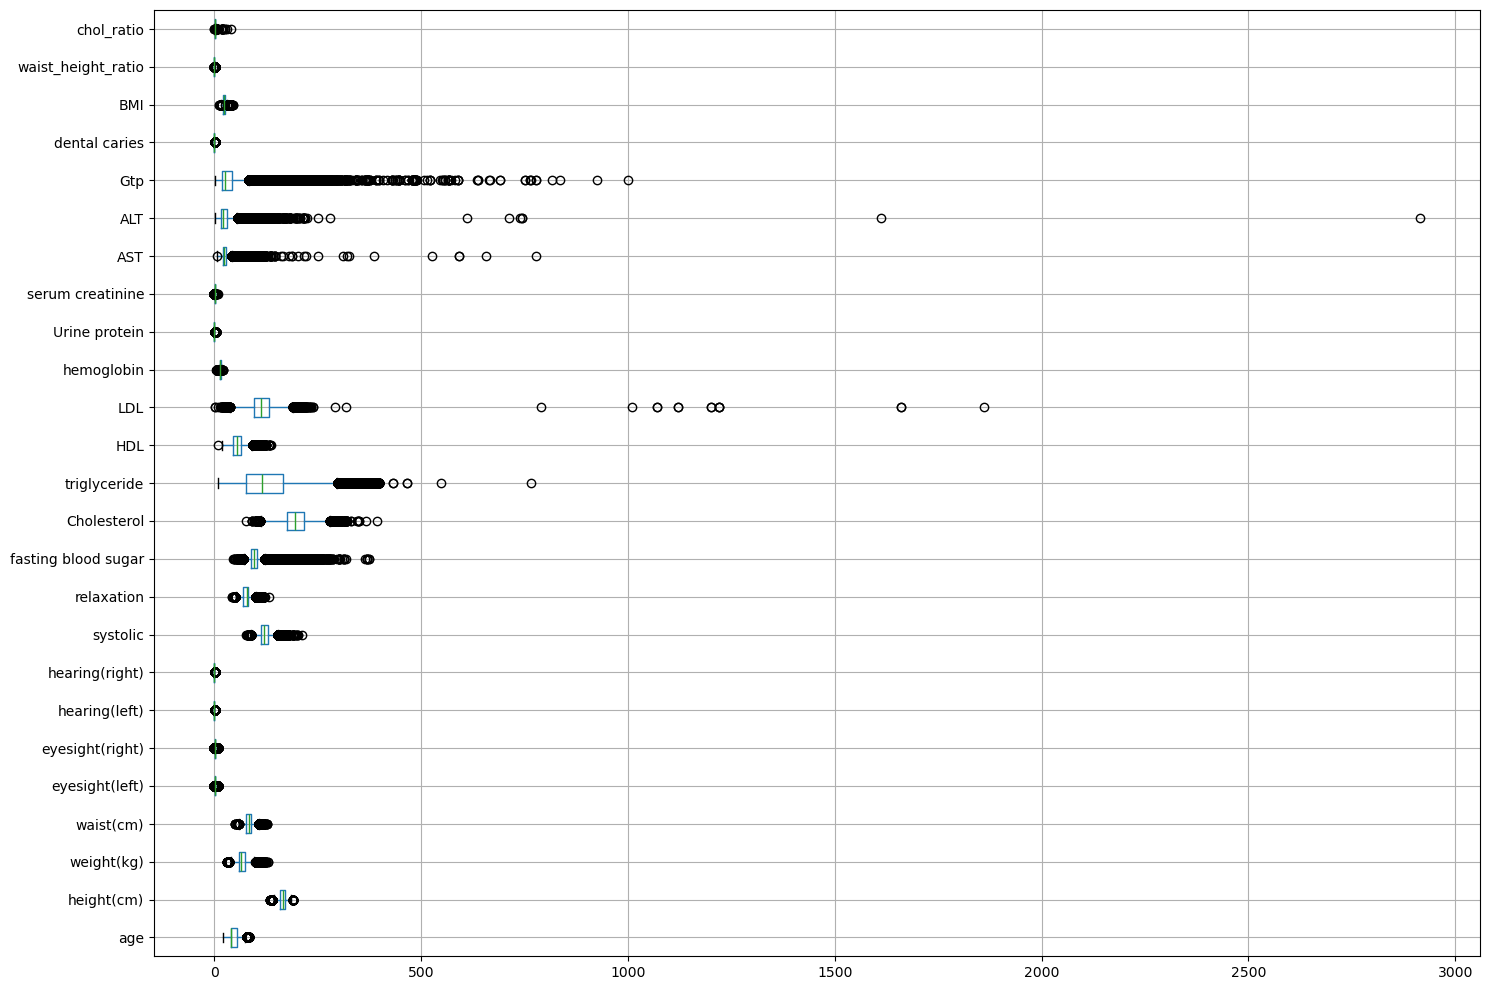

In [76]:
X_train.boxplot(figsize=(15, 10), vert=False) # Обнаружение выбросов
plt.tight_layout()

Поскольку мы очищаем данные от выбросов в отдельном датафрейме для дальнейшего сравнения метрик модели на необработанных, обработанных данных с выбросами и обработанных данных без выбросов, произведем перекодирование также для датафрейма, из которого мы планируем убирать выбросы

In [79]:
columns_un_values = ['hearing(left)', 'hearing(right)', 'Urine protein', 'dental caries']
def check_unique(dataframe):
    for column in columns_un_values:
        print(dataframe[column].value_counts())
     
print(check_unique(df_cleaned_from_outliers))
df_cleaned_from_outliers

hearing(left)
1    155438
2      3818
Name: count, dtype: int64
hearing(right)
1    155526
2      3730
Name: count, dtype: int64
Urine protein
1    150862
2      5609
3      2228
4       477
5        74
6         6
Name: count, dtype: int64
dental caries
0    127724
1     31532
Name: count, dtype: int64
None


,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking,BMI,waist_height_ratio,chol_ratio
id,,,,,,,,,,,,,,,,,,,,,
0,55,165,60,81.0,0.5,0.6,1,1,135,87,...,1,1.0,22,25,27,0,1,22.038567,0.490909,1.875000
1,70,165,65,89.0,0.6,0.7,2,2,146,83,...,1,1.1,27,23,37,1,0,23.875115,0.539394,2.210526
2,20,170,75,81.0,0.4,0.5,1,1,118,75,...,1,0.8,27,31,53,0,1,25.951557,0.476471,2.066667
3,35,180,95,105.0,1.5,1.2,1,1,131,88,...,1,1.0,20,27,30,1,0,29.320988,0.583333,2.684211
4,30,165,60,80.5,1.5,1.0,1,1,121,76,...,1,0.8,19,13,17,0,1,22.038567,0.487879,2.113636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159251,40,155,45,69.0,1.5,2.0,1,1,127,80,...,1,0.8,25,26,13,0,0,18.730489,0.445161,2.208333
159252,50,155,75,82.0,1.0,1.0,1,1,120,80,...,1,0.6,21,20,18,0,0,31.217482,0.529032,1.687500
159253,40,160,50,66.0,1.5,1.0,1,1,114,70,...,1,0.6,15,9,12,0,0,19.531250,0.412500,1.068966


**Используем IQR для выявления и последующего удаления выбросов**

In [82]:
columns_with_outliers = ['age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)',
       'eyesight(right)', 'systolic',
       'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride',
       'HDL', 'LDL', 'hemoglobin', 'serum creatinine', 'AST',
       'ALT', 'Gtp', 'BMI', 'waist_height_ratio', 'chol_ratio']  # Все исходные столбцы, кроме категориальных

df_cleaned_from_outliers = df_cleaned_from_outliers.copy()  #явно создаем копию, так без нее выводятся предупреждения

for column in columns_with_outliers:
    Q1 = df_cleaned_from_outliers.loc[:, column].quantile(0.25)  # Первый квартиль для столбца: значение, ниже которого находится 25% данных
    Q3 = df_cleaned_from_outliers.loc[:, column].quantile(0.75)  # Третий квартиль для столбца: значение, ниже которого находится 75% данных
    IQR = Q3 - Q1  # Межквартильный размах: разница между третьим и первым квартилем
    lower_bound = Q1 - 1.5 * IQR # Нижняя граница. Значения за пределами нижней и верхней границы - выбросы
    upper_bound = Q3 + 1.5 * IQR # Верхняя граница
    
    # Добавляем новый столбец с флагами выбросов для каждого столбца
    df_cleaned_from_outliers.loc[:, f'{column}_IQR_Outlier'] = (df_cleaned_from_outliers[column] < lower_bound) | (df_cleaned_from_outliers[column] > upper_bound)
    
    # Считаем количество выбросов
    outliers_number = df_cleaned_from_outliers[f'{column}_IQR_Outlier'].value_counts().get(True, 0)
    print(f'Значений с выбросами в столбце {column}: {outliers_number}')

    # Удаляем выбросы (значения, помеченные как True в столбце флага выбросов)
    df_cleaned_from_outliers = df_cleaned_from_outliers[~df_cleaned_from_outliers[f'{column}_IQR_Outlier']]  # Убираем все строки с выбросами для данного столбца; ~ означает инвертирование булевой маски
    
    # Удаляем временный столбец с флагами выбросов
    df_cleaned_from_outliers.drop(columns=[f'{column}_IQR_Outlier'], inplace=True)

# Выводим результат после удаления выбросов
print(f"Осталось строк в df_cleaned_from_outliers после удаления выбросов: {df_cleaned_from_outliers.shape[0]}")

Значений с выбросами в столбце age: 682
Значений с выбросами в столбце height(cm): 439
Значений с выбросами в столбце weight(kg): 2270
Значений с выбросами в столбце waist(cm): 292
Значений с выбросами в столбце eyesight(left): 2225
Значений с выбросами в столбце eyesight(right): 1826
Значений с выбросами в столбце systolic: 1443
Значений с выбросами в столбце relaxation: 661
Значений с выбросами в столбце fasting blood sugar: 7410
Значений с выбросами в столбце Cholesterol: 292
Значений с выбросами в столбце triglyceride: 2572
Значений с выбросами в столбце HDL: 1560
Значений с выбросами в столбце LDL: 182
Значений с выбросами в столбце hemoglobin: 1332
Значений с выбросами в столбце serum creatinine: 4922
Значений с выбросами в столбце AST: 4823
Значений с выбросами в столбце ALT: 4519
Значений с выбросами в столбце Gtp: 6677
Значений с выбросами в столбце BMI: 1029
Значений с выбросами в столбце waist_height_ratio: 747
Значений с выбросами в столбце chol_ratio: 571
Осталось строк в 

**Используем DBSCAN для выявления и последующего удаления выбросов**

- Попробуем подобрать оптимальные параметры гиперпараметры **eps** (радиус окрестности для каждой точки) и **min_samples** (минимальное число точек в окрестности, чтобы точка считалась кластерной).
- Предварительно произведем нормализацию, так как на исходных данных обнаружить кластеры не удается.
- Подбор оптимальных параметров произведем на небольшой выборке из исходного датафрейма ввиду ограничения мощностей.

In [90]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

df_cleaned_sample = df_cleaned_from_outliers.sample(n=5000, random_state=42)
df_cleaned_sample = StandardScaler().fit_transform(df_cleaned_sample)

samples_number = np.arange(14, 19, 1) # Диапазон значений параметра min_samples, подобран тестированием различных диапазонов
eps = np.arange(6, 7, 0.1)  # Диапазон значений параметра eps, подобран тестированием различных диапазонов


silh = {}  # Для хранения силуэтных коэффициентов и параметров
clusters_info = {}  # Для хранения информации о кластерах
for n in samples_number: 
    for e in eps:
        clusters = DBSCAN(eps=e, min_samples=n).fit(df_cleaned_sample) #определяет кластеры для текущего набора данных
        labels = clusters.labels_
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)  # Учитываем шумовые точки (-1)
        if len(set(labels)) > 1:  # Убедиться, что как минимум два кластера
            score = silhouette_score(df_cleaned_sample, labels, metric='euclidean') #silhouette_score оценивает качество кластеризации (чем ближе к 1, тем лучше)
            silh.update({score: [e, n]})
            clusters_info[score] = n_clusters
        #    print(e, n, score)
        #else:
        #    print('Мало кластеров')


best_score = max(silh.keys())  # Максимальный силуэтный коэффициент
best_eps, best_min_samples = silh[best_score]
best_n_clusters = clusters_info[best_score]
print(f'Лучшие гиперпараметры: e={best_eps:.2f}, min_samples={best_min_samples}, silhouette_score={best_score:.4f}, кластеров: {best_n_clusters}')

Лучшие гиперпараметры: e=6.90, min_samples=18, silhouette_score=0.2989, кластеров: 4


Применим DBSCAN на выборке

In [92]:
clusters = DBSCAN(eps=best_eps, min_samples=best_min_samples).fit(df_cleaned_sample)
labels = clusters.labels_  #labels_ хранит метки, которые были присвоены каждой точке в процессе кластеризации. Если точка является выбросом, то для неё присваивается метка -1

# Отбираем только те строки, которые не являются выбросами (не имеют метки -1)
mask = labels != -1  # Булев массив: True для точек, которые не выбросы
df_dbscan_cleaned = df_cleaned_sample[mask]

# Выводим информацию об удалении выбросов
removed_outliers = df_cleaned_sample.shape[0] - df_dbscan_cleaned.shape[0]
print(f'Удалено {removed_outliers} выбросов.')

Удалено 2 выбросов.


**Произведение логарифмирование признаков с выбросами**

In [88]:
print(X_train.columns)

Index(['age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)',
       'eyesight(right)', 'hearing(left)', 'hearing(right)', 'systolic',
       'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride',
       'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum creatinine', 'AST',
       'ALT', 'Gtp', 'dental caries', 'BMI', 'waist_height_ratio',
       'chol_ratio'],
      dtype='object')


        age  height(cm)  weight(kg)  waist(cm)  eyesight(left)  \
id                                                               
0        55         165          60       81.0             0.5   
1        70         165          65       89.0             0.6   
2        20         170          75       81.0             0.4   
3        35         180          95      105.0             1.5   
4        30         165          60       80.5             1.5   
...     ...         ...         ...        ...             ...   
159251   40         155          45       69.0             1.5   
159252   50         155          75       82.0             1.0   
159253   40         160          50       66.0             1.5   
159254   50         165          75       92.0             1.2   
159255   40         145          45       76.4             1.0   

        eyesight(right)  hearing(left)  hearing(right)  systolic  relaxation  \
id                                                           

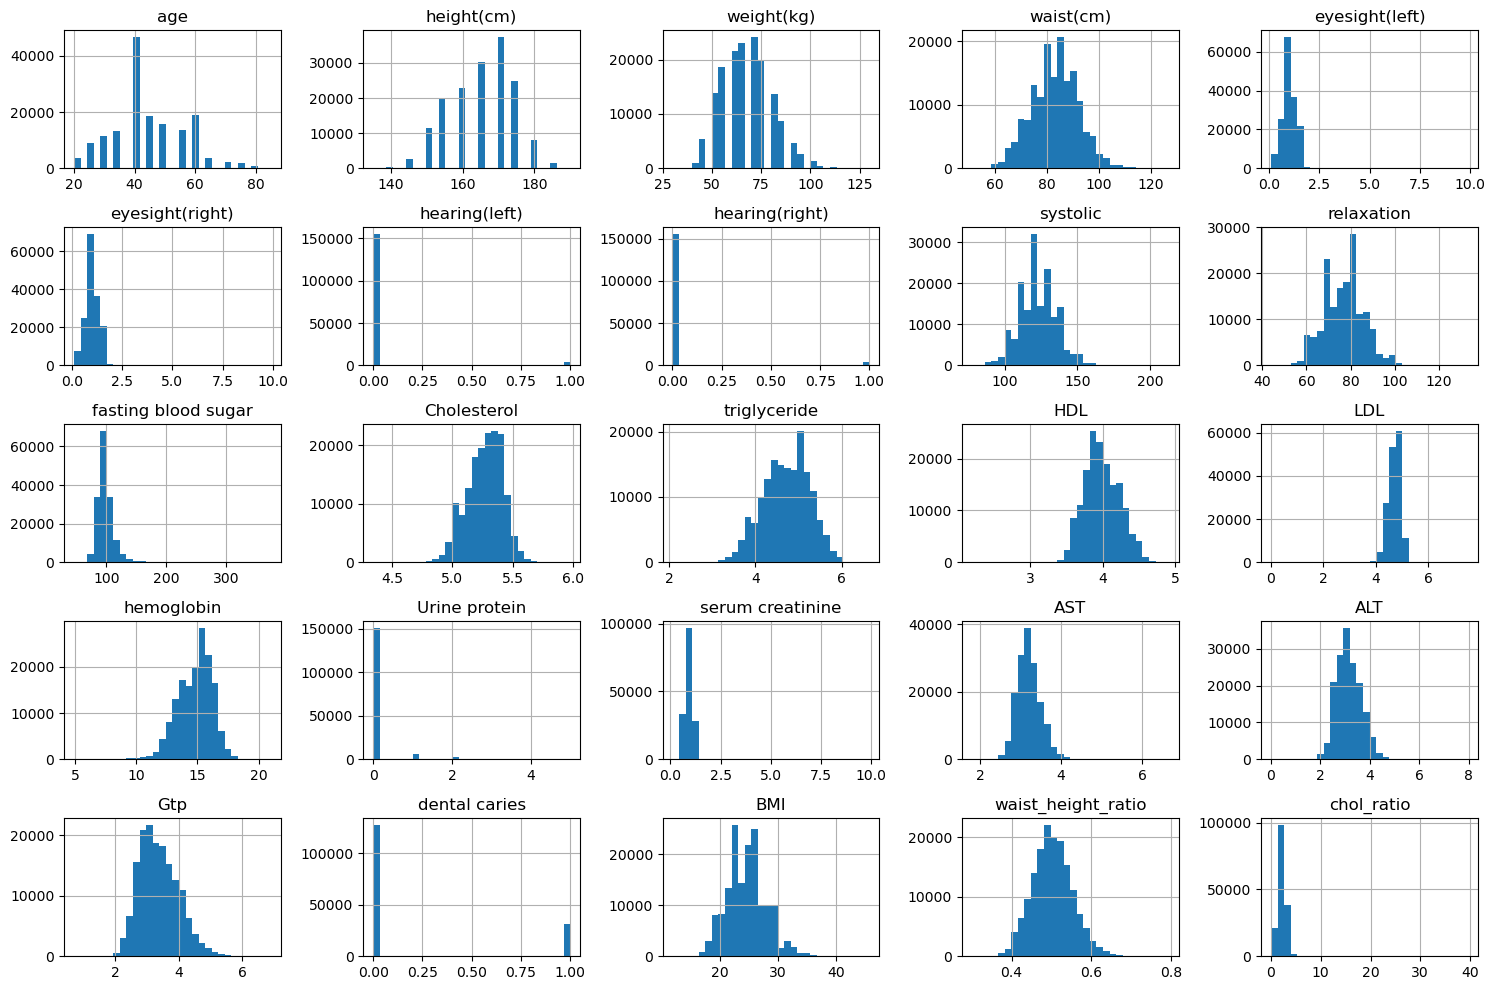

In [89]:
columns_log = ['Cholesterol','triglyceride', 'LDL', 'HDL', 'AST', 'ALT', 'Gtp'] # Находим признаки с большими выбросами, добавляем в переменную
def log_func(dataframe):
    dataframe[columns_log] = dataframe[columns_log].map(lambda x: x if x > 0 else 1) # Логарифмируем признаки с большими выбросами
    dataframe[columns_log] = np.log(dataframe[columns_log])
    dataframe.hist(bins=30, figsize=(15, 10)) # Строим гистограмму
    plt.tight_layout()
    None
    #plt.savefig('g.png')
    return dataframe

print(log_func(X_train))

**Видим, что распределение признаков стало нормальным, более приближенным к колоколообразной форме**

**Далее стандартизируем значения числовых переменных**

In [92]:
columns_scale = ['age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)',
       'eyesight(right)', 'systolic',
       'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride',
       'HDL', 'LDL', 'hemoglobin', 'serum creatinine', 'AST',
       'ALT', 'Gtp', 'BMI', 'waist_height_ratio',
       'chol_ratio']


In [93]:
scaler = StandardScaler()
X_train[columns_scale] = scaler.fit_transform(X_train[columns_scale])
X_train

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,BMI,waist_height_ratio,chol_ratio
id,,,,,,,,,,,,,,,,,,,,,
0,0.902985,-0.030268,-0.567581,-0.223489,-1.257856,-1.022156,0,0,0.981702,1.125777,...,1.189928,0,0.597927,-0.338123,0.143437,-0.121179,0,-0.716686,-0.231003,-0.410745
1,2.169636,-0.030268,-0.170319,0.669577,-1.009169,-0.767247,1,1,1.845852,0.681066,...,0.980315,0,1.155511,0.350584,-0.024532,0.384063,1,-0.171497,0.736048,0.036043
2,-2.052535,0.536694,0.624205,-0.223489,-1.506543,-1.277064,0,0,-0.353802,-0.208355,...,1.818767,0,-0.517239,0.350584,0.576769,0.960330,0,0.444907,-0.518985,-0.155521
3,-0.785883,1.670617,2.213252,2.455708,1.229017,0.507296,0,0,0.667465,1.236955,...,0.770702,0,0.597927,-0.658643,0.298471,0.047770,1,1.445142,1.612438,0.666802
4,-1.208100,-0.030268,-0.567581,-0.279305,1.229017,-0.002521,0,0,-0.118125,-0.097177,...,0.421347,0,-0.517239,-0.831138,-1.173870,-0.863009,0,-0.716686,-0.291443,-0.092976
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159251,-0.363666,-1.164191,-1.759366,-1.563087,1.229017,2.546566,0,0,0.353229,0.347533,...,-0.207493,0,-0.517239,0.091771,0.222445,-1.293178,0,-1.698708,-1.143462,0.033123
159252,0.480768,-1.164191,0.624205,-0.111855,-0.014419,-0.002521,0,0,-0.196684,0.347533,...,-0.207493,0,-1.632406,-0.494566,-0.306076,-0.771354,0,2.008127,0.529380,-0.660420
159253,-0.363666,-0.597229,-1.362104,-1.897986,1.229017,-0.002521,0,0,-0.668039,-0.764243,...,-2.722849,0,-1.632406,-1.626094,-1.914635,-1.421529,0,-1.460997,-1.794906,-1.484062


**Таким образом, датасет предобработан, готов к анализу и построению модели**

**На данном этапе мы приняли решение о предобработке тестовой выборки, чтобы убедиться, что все функции работают исправно**

In [96]:
df_test = pd.read_csv("test.csv", index_col='id')
print(df_test.columns)
print(df_test.shape) 

Index(['age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)',
       'eyesight(right)', 'hearing(left)', 'hearing(right)', 'systolic',
       'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride',
       'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum creatinine', 'AST',
       'ALT', 'Gtp', 'dental caries'],
      dtype='object')
(106171, 22)


**Убедились, что все столбцы из тренировочной выборки присутствуют (за исключением таргетной переменной). Далее запустим ранее сформированные функции для предобработки датасета. На данном этапе закомментируем этот блок**

In [98]:
# #X_test = duplicates_nan(df_test)
# X_test = recoding(X_test)
# X_test = log_func(X_test)
# X_test[columns_scale] = scaler.transform(X_test[columns_scale])
# X_test

**На данном этапе мы завершили преобработку тестовой выборки и перешли к созданию модели, ее обучению и предсказаниям**

In [22]:
model = LogisticRegression(solver='liblinear', random_state=42)

In [101]:
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)

**Оценим качество предсказания на тренировочной выборке**

In [103]:
accuracy = accuracy_score(y_train, y_train_pred)
precision = precision_score(y_train, y_train_pred)
recall = recall_score(y_train, y_train_pred)
f1 = f1_score(y_train, y_train_pred)
roc_auc = roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'ROC AUC: {roc_auc}')

Accuracy: 0.760115788416135
Precision: 0.711910088133035
Recall: 0.7584454366646088
F1 Score: 0.734441362723222
ROC AUC: 0.8430469315232161


**Оценим качество предсказания на тренировочной выборке, используя для обучения очищенный от выбросов датасет.**

In [23]:
y_train_cleaned_from_outliers = df_cleaned_from_outliers['smoking']
X_train_cleaned_from_outliers = df_cleaned_from_outliers.drop(columns = ['smoking'])

model.fit(X_train_cleaned_from_outliers, y_train_cleaned_from_outliers)
y_train_pred = model.predict(X_train_cleaned_from_outliers)

accuracy = accuracy_score(y_train_cleaned_from_outliers, y_train_pred)
precision = precision_score(y_train_cleaned_from_outliers, y_train_pred)
recall = recall_score(y_train_cleaned_from_outliers, y_train_pred)
f1 = f1_score(y_train_cleaned_from_outliers, y_train_pred)
roc_auc = roc_auc_score(y_train_cleaned_from_outliers, model.predict_proba(X_train_cleaned_from_outliers)[:, 1])

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'ROC AUC: {roc_auc}')

Accuracy: 0.7480715007713997
Precision: 0.6949299040792664
Recall: 0.7027672366008613
F1 Score: 0.6988265971316818
ROC AUC: 0.834571625412669


**Вывод 1: модель демонстрирует среднее качество. Мы использовали кросс-валидацию для отбора лучших параметров модели. Между тем, на данном этапе модель с другими параметрами не продемонстрировала ощутимого улучшения метрик (все улучшения были в масштабе 0.01%), поэтому тонкая настройка была исключена из настоящего файла, и за стандартную модель была выбрана текущая дефолтная модель**

**Вывод 2: добавление новых признаков продемонстрировало незначительное улучшение метрики accuracy и сопоставимое снижение некоторых других метрик. Напомним, что ранее метрики были следующими**

Accuracy: 0.7584580800723364

Precision: 0.7112643615868198

Recall: 0.7536933082566436

F1 Score: 0.7318644091425545

ROC AUC: 0.8419585393052988


**Дополнительно исследуем полиномиальную модель, которая возводит признаки в степень для поиска нелинейной связи, что косвенно относится также к обработке признаков**

In [107]:
X_train.columns

Index(['age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)',
       'eyesight(right)', 'hearing(left)', 'hearing(right)', 'systolic',
       'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride',
       'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum creatinine', 'AST',
       'ALT', 'Gtp', 'dental caries', 'BMI', 'waist_height_ratio',
       'chol_ratio'],
      dtype='object')

In [108]:
columns_polynome = ['hemoglobin', 'height(cm)', 'weight(kg)', 'Gtp', 'Cholesterol', 'BMI', 'waist_height_ratio',
       'chol_ratio', 'systolic',
       'relaxation', 'age', 'AST',
       'ALT', 'dental caries', 'triglyceride', 'HDL', 'LDL']

In [115]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline


model2 = make_pipeline(PolynomialFeatures(degree=2), LogisticRegression(solver='liblinear'))
model2.fit(X_train[columns_polynome], y_train)
y_train_pred_2 = model2.predict(X_train[columns_polynome])
accuracy_2 = accuracy_score(y_train, y_train_pred_2)
precision_2 = precision_score(y_train, y_train_pred_2)
recall_2 = recall_score(y_train, y_train_pred_2)
f1_2 = f1_score(y_train, y_train_pred_2)
roc_auc_2 = roc_auc_score(y_train, model2.predict_proba(X_train[columns_polynome])[:, 1])

print(f'Accuracy for raw DataFrame: {raw_accuracy}')
print(f'Precision for raw DataFrame: {raw_precision}')
print(f'Recall for raw DataFrame: {raw_recall}')
print(f'F1 Score for raw DataFrame: {raw_f1}')
print(f'ROC AUC for raw DataFrame: {raw_roc_auc}')

print(f'Accuracy: {accuracy_2}')
print(f'Precision: {precision_2}')
print(f'Recall: {recall_2}')
print(f'F1 Score: {f1_2}')
print(f'ROC AUC: {roc_auc_2}')

Accuracy for raw DataFrame: 0.7487943939317828
Precision for raw DataFrame: 0.7041888783283056
Recall for raw DataFrame: 0.7339525935709876
F1 Score for raw DataFrame: 0.7187627416520211
ROC AUC for raw DataFrame: 0.8347246958267175
Accuracy: 0.7719646355553323
Precision: 0.7112316407091533
Recall: 0.8057657243765524
F1 Score: 0.7555531622734983
ROC AUC: 0.8536201154540657


**Вывод: добиться увеличения метрик посредством обучения полиномиальной модели только на тех признаках, которые были отобраны в соответствии с ранее приведенными тестами в рамках инженерии данных, не удалось, в это связи для обучения модели были взяты практически все признаки, которые у нас хватило производительности обработать. Наблюдаем улучшение качества модели. Предполагаем, что связь ряда признаков с таргетной переменной может быть нелинейной.**

**Дополнительное исследование от аналитика**

Наш аналитик исследовал возможные направления применения данного датасета:
1. Здравоохранение и профилактика:
   - Идентификация курильщиков: использование датасета для выявления курильщиков среди пациентов (это может помочь врачам в предоставлении более целенаправленных и персонализированных рекомендаций для лечения, направленного на отказ от курения).
   - Мониторинг здоровья: слежение за состоянием здоровья пациентов с целью определения риска развития заболеваний, связанных с курением.

2. Научные исследования:
   - Изучение влияния курения на биосигналы: проведение различных анализов (как курение влияет на различные биосигналы, и как такие исследования могут помогать в понимании физиологических изменений, вызванных курением).
   - Разработка новых методов диагностики: создание новых методов диагностики (могут использоваться для раннего выявления курильщиков и связанных с курением болячек).

3. Медицинские страховые компании:
   - Оценка рисков: страховые компании могут использовать модель для оценки рисков, связанных с курением (и корректировать страховые премии).

4. Программы отказа от курения:
   - Персонализированные программы: разработка персонализированных программ отказа от курения на основе специфических биосигналов и характеристик человека.

**Полный отчет имеется у аналитика и может быть представлен по запросу.**

In [114]:
Image(url='https://repository-images.githubusercontent.com/210049911/4ebd7880-dd46-11e9-934a-bab222668ed0', width=1050, height=150)

NameError: name 'Image' is not defined